### Inporting Important Libraries

In [33]:
import cv2
import dlib
import imageio
import os
from IPython.display import Image
from IPython.display import display
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Reading the Images

In [34]:
image1 = cv2.imread('image4.jpeg')
image2 = cv2.imread('image1.jpeg')

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

### Function for Finding feature points

In [35]:
def get_feature_points(image):

    predictor_path = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    face = detector(image)
    shape = predictor(image, face[0])
    feature_points = np.zeros((76, 2), dtype=np.int32)

    for i in range(68):
        x = shape.part(i).x
        y = shape.part(i).y
        feature_points[i] = [x,y]

    h,w = image.shape[:2]
    feature_points[68] = [0,0]
    feature_points[69] = [w-1,0]
    feature_points[70] = [0,h-1]
    feature_points[71] = [w-1,h-1]
    feature_points[72] = [int(w/2),0]
    feature_points[73] = [0,int(h/2)]
    feature_points[74] = [w-1,int(h/2)]
    feature_points[75] = [int(w/2),h-1]
    
    return feature_points

### Function to Apply Image Morphism

In [36]:
def morph_image(tri_indices_img1):
    
    number_of_frames = 50

    step = 1 / number_of_frames

    alpha = 0

    images = []

    while alpha <= 1:

        number_of_triangles = len(tri_indices_img1)

        # Creating the triangles in the intermediate image

        inter_tri = np.zeros((number_of_triangles, 3, 2), dtype = np.float32)

        k = 0

        for tri in tri_indices_img1:

            intx1, inty1 = (1 - alpha) * feature_points_1[tri[0]] + alpha * feature_points_2[tri[0]]
            intx2, inty2 = (1 - alpha) * feature_points_1[tri[1]] + alpha * feature_points_2[tri[1]]
            intx3, inty3 = (1 - alpha) * feature_points_1[tri[2]] + alpha * feature_points_2[tri[2]]

            inter_tri[k] = np.array([[int(intx1), int(inty1)], [int(intx2), int(inty2)], [int(intx3), int(inty3)]])

            k = k + 1


        # Initializing an empty intermediate image

        inter_image = np.zeros(image1.shape, dtype = np.uint8)


        # For every triangle in the intermediate image run the following loop

        i = 0

        for triangle in inter_tri:

            # Creating np array of corresponding input triangle coordinates

            inp_tri = np.array([
                feature_points_1[tri_indices_img1[i][0]], 
                feature_points_1[tri_indices_img1[i][1]], 
                feature_points_1[tri_indices_img1[i][2]]
            ], dtype = np.float32)

            # Just renaming the intermediate image triangle

            int_tri = triangle

            # Creating np array of corresponding output triangle coordinates

            out_tri = np.array([
                feature_points_2[tri_indices_img1[i][0]], 
                feature_points_2[tri_indices_img1[i][1]], 
                feature_points_2[tri_indices_img1[i][2]]
            ], dtype = np.float32)


            # Finding smallest axis parallel rectangle that encloses the input triangle
            # inp_tri_br_x, inp_tri_br_y are the top left corner coordinates of this rectangle

            inp_tri_br_x, inp_tri_br_y, inp_tri_br_w, inp_tri_br_h = cv2.boundingRect(inp_tri)

            inp_rect = image1[inp_tri_br_y: inp_tri_br_y + inp_tri_br_h, inp_tri_br_x: inp_tri_br_x + inp_tri_br_w]


            # Finding smallest axis parallel rectangle that encloses the input triangle

            int_tri_br_x, int_tri_br_y, int_tri_br_w, int_tri_br_h = cv2.boundingRect(int_tri)

            int_rect = inter_image[int_tri_br_y: int_tri_br_y + int_tri_br_h, int_tri_br_x: int_tri_br_x + int_tri_br_w]

            # Finding smallest axis parallel rectangle that encloses the input triangle

            out_tri_br_x, out_tri_br_y, out_tri_br_w, out_tri_br_h = cv2.boundingRect(out_tri)

            out_rect = image2[out_tri_br_y: out_tri_br_y + out_tri_br_h, out_tri_br_x: out_tri_br_x + out_tri_br_w]

            # Finding the relative position of each triangles in their respective enclosing rectangles

            inp_tri_rel_coor = np.zeros((3,2), dtype = np.float32)
            out_tri_rel_coor = np.zeros((3,2), dtype = np.float32)
            int_tri_rel_coor = np.zeros((3,2), dtype = np.float32)

            for j in range(0, 3):
                
                int_tri_rel_coor[j][0] = int_tri[j][0] - int_tri_br_x
                int_tri_rel_coor[j][1] = int_tri[j][1] - int_tri_br_y
                
                
                inp_tri_rel_coor[j][0] = inp_tri[j][0] - inp_tri_br_x
                inp_tri_rel_coor[j][1] = inp_tri[j][1] - inp_tri_br_y
                
                
                out_tri_rel_coor[j][0] = out_tri[j][0] - out_tri_br_x
                out_tri_rel_coor[j][1] = out_tri[j][1] - out_tri_br_y


            # Creating the ransformation matrices corresponding to the relative indexes

            M_inp = cv2.getAffineTransform(inp_tri_rel_coor, int_tri_rel_coor)

            M_out = cv2.getAffineTransform(out_tri_rel_coor, int_tri_rel_coor)


            # Trnaforming the input and output rectangles with to the corresponding trnasformation Matrices

            warped_rect_inp = cv2.warpAffine(inp_rect, M_inp, (int_tri_br_w, int_tri_br_h), None, flags=cv2.INTER_CUBIC)

            warped_rect_out = cv2.warpAffine(out_rect, M_out, (int_tri_br_w, int_tri_br_h), None, flags=cv2.INTER_CUBIC)


            # Calculating the corresponding resultant rectangle in the intermediate image

            r_rect = (1-alpha) * warped_rect_inp + alpha * warped_rect_out


            # Creating a mask to pick only the triangle values from the resultant rectangle

            mask_int = np.zeros((int_tri_br_h, int_tri_br_w, 3), dtype = np.float32)

            cv2.fillConvexPoly(mask_int, np.int32(int_tri_rel_coor), (1.0, 1.0, 1.0), 16, 0)


            # Putting the result rectangle value in corresponding position in the intermediate image
            # the rectangle is mutiplied with the inverse of the mask to cancel out the values outside of the triangle

            inter_image[int_tri_br_y: int_tri_br_y + int_tri_br_h, int_tri_br_x: int_tri_br_x + int_tri_br_w] = inter_image[int_tri_br_y: int_tri_br_y + int_tri_br_h, int_tri_br_x: int_tri_br_x + int_tri_br_w] * (1 - mask_int) + r_rect * mask_int

            i = i + 1

        alpha = alpha + step

        images.append(inter_image)

    imageio.mimsave('output_file.gif', images, duration=0.1)

### Function to add four corner points to the feature point set

In [37]:
def add_corner_points(points, image):
    h, w = image.shape[:2]
    np.hstack((points, [(0, 0)]))
    np.hstack((points, [(w-1, 0)]))
    np.hstack((points, [(0, h-1)]))
    np.hstack((points, [(w-1, h-1)]))
    
    return points

### Taking input from user whether the points are to be selected automatically or to be given in 'points.txt' file

In [38]:
option = input('Enter 1 to detect feature points automatically\nEnter 2 to give feature points via .txt file\n')



feature_points_1 = []
feature_points_2 = []

if int(option) == 1:
    
    feature_points_1 = get_feature_points(image1)
    feature_points_2 = get_feature_points(image2)
    
    triangles = Delaunay(feature_points_1)
    tri_indices_img1 = triangles.simplices
    
    morph_image(tri_indices_img1)
    
elif int(option) == 2:
    
    with open('points.txt', 'r') as f:
        lines = f.readlines()
        num_of_points = int(lines[0].strip())
        i = 1
        while i <= num_of_points:
            point = lines[i].strip().split(' ')
            feature_points_1.append(np.array([point[0], point[1]]))
            feature_points_2.append(np.array([point[2], point[3]]))
            
    feature_points_1 = np.array(feature_points_1, dtype = np.int32)
    feature_points_2 = np.array(feature_points_2, dtype = np.int32)
    
    feature_points_1 = add_corner_points(feature_points_1, image1)
    feature_points_2 = add_corner_points(feature_points_2, image2)
    
    triangles = Delaunay(feature_points_1)
    tri_indices_img1 = triangles.simplices
    
    morph_image(tri_indices_img1)

Enter 1 to detect feature points automatically
Enter 2 to give feature points via .txt file
1


### Creating GIF of the intermediate images

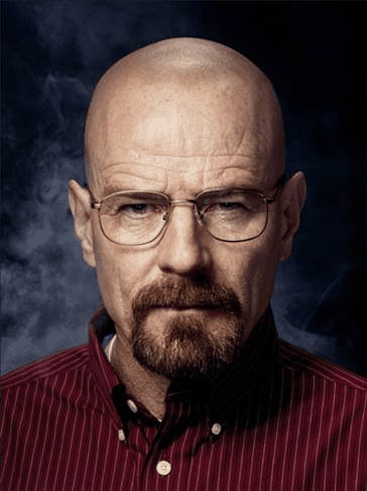

In [39]:
with open('output_file.gif','rb') as f:
    display(Image(data=f.read(), format='png'))